In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from src.GP.data import *
from src.GP.plotting import *
from src.GP.GP import *
from src.GP.utils import *

import scienceplots

plt.style.use('science')

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfoundeded_func_plot = lambda X,T: 1+T+X[:,0]+2*T*X[:,0]+0.5*X[:,0]**2+0.75*T*X[:,0]**2+2*(T-0.5)*X[:,0]**2
uncfoundeded_func_plot = lambda X,T: 1+T+X[:,0]+2*T*X[:,0]+0.5*X[:,0]**2+0.75*T*X[:,0]**2

plot_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func_plot,
              uncfounded_func = uncfoundeded_func_plot)

cfoundeded_CATE_func = lambda X,T: cfoundeded_func_plot(X,1) - cfoundeded_func_plot(X,0)

T_prop = 0.5
n_samples_exp = 200
n_samples_obs = 1000

In [3]:
exp_data,obs_data,outcome_funcs_GP = get_train_data_GP(plot_outcome_funcs ,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,sigma_noise=0.5,kernel="RBF",d=1)

(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X', ylabel='None'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X', ylabel='None'>],
       dtype=object))

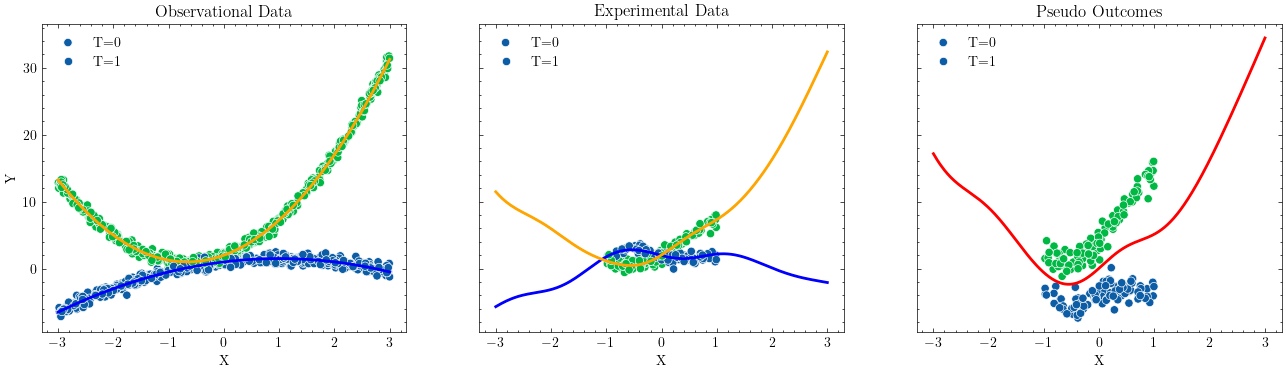

In [4]:
obs_exp_pseudo_plot(obs_data,exp_data,outcome_funcs_GP,T_prop=T_prop)

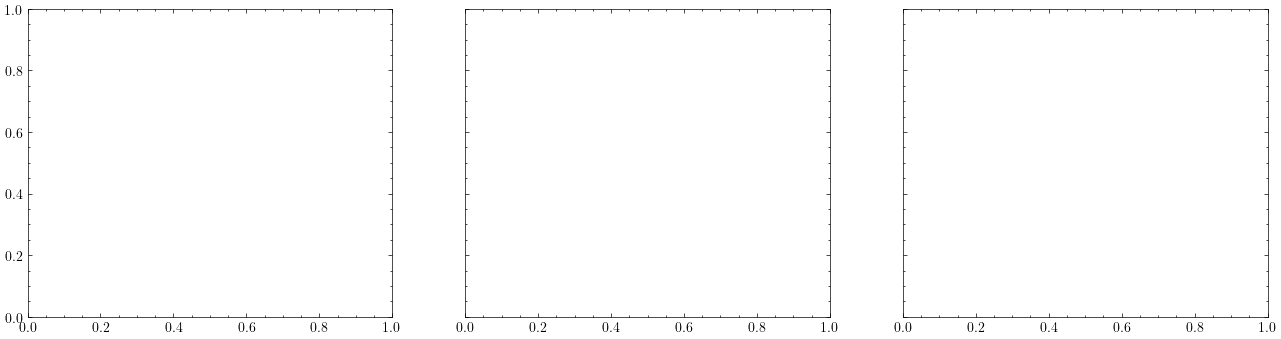

In [5]:
fig, axs= plt.subplots(ncols=3,sharex=True,figsize=(16,4),sharey=True)

In [6]:
pseudo_data = get_pseudo_outcome_data(exp_data,T_prop=T_prop)
pseudo_data_adjusted = adjust_data(pseudo_data,cfoundeded_CATE_func)

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = FixedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop,Train=False)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward(retain_graph=True)
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()
    # # loss.zero_grad()


model.eval()
likelihood.eval()

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/torch/csrc/utils/tensor_new.cpp:643.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/50 - Loss: 1.742
Iter 2/50 - Loss: 1.713
Iter 3/50 - Loss: 1.690
Iter 4/50 - Loss: 1.673
Iter 5/50 - Loss: 1.661
Iter 6/50 - Loss: 1.653
Iter 7/50 - Loss: 1.647
Iter 8/50 - Loss: 1.643
Iter 9/50 - Loss: 1.641
Iter 10/50 - Loss: 1.640
Iter 11/50 - Loss: 1.640
Iter 12/50 - Loss: 1.641
Iter 13/50 - Loss: 1.641
Iter 14/50 - Loss: 1.642
Iter 15/50 - Loss: 1.643
Iter 16/50 - Loss: 1.644
Iter 17/50 - Loss: 1.644
Iter 18/50 - Loss: 1.645
Iter 19/50 - Loss: 1.645
Iter 20/50 - Loss: 1.645
Iter 21/50 - Loss: 1.645
Iter 22/50 - Loss: 1.645
Iter 23/50 - Loss: 1.644
Iter 24/50 - Loss: 1.644
Iter 25/50 - Loss: 1.643
Iter 26/50 - Loss: 1.643
Iter 27/50 - Loss: 1.642
Iter 28/50 - Loss: 1.641
Iter 29/50 - Loss: 1.641
Iter 30/50 - Loss: 1.640
Iter 31/50 - Loss: 1.640
Iter 32/50 - Loss: 1.639
Iter 33/50 - Loss: 1.639
Iter 34/50 - Loss: 1.639
Iter 35/50 - Loss: 1.639
Iter 36/50 - Loss: 1.639
Iter 37/50 - Loss: 1.639
Iter 38/50 - Loss: 1.639
Iter 39/50 - Loss: 1.639
Iter 40/50 - Loss: 1.639
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [8]:
X_plot = torch.linspace(-3, 3, 1000).unsqueeze(1)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()
X_plot = torch.linspace(-3, 3, 1000)

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_28982/3418442447.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


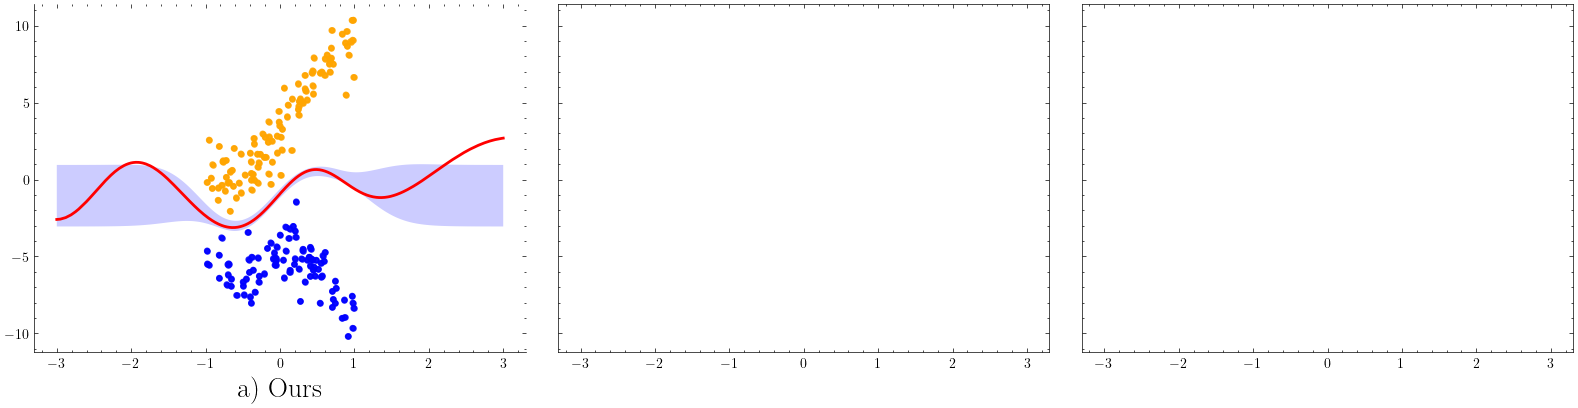

In [9]:
FIGSIZE = (16,4)
fig, axs = plt.subplots(ncols=3,sharex=True,figsize=FIGSIZE,sharey=True)
fig.tight_layout()
axs[0].set_axisbelow(True)
axs[0].set_title("a) Ours",y=-0.15,fontsize = 20)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
colors = ["blue","orange"]

scatter = axs[0].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[0].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)


axs[0].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95\% CI')

In [10]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = PseudoOutcome_StandardGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 20.757
Iter 2/50 - Loss: 19.409
Iter 3/50 - Loss: 18.188
Iter 4/50 - Loss: 17.083
Iter 5/50 - Loss: 16.084
Iter 6/50 - Loss: 15.182
Iter 7/50 - Loss: 14.368
Iter 8/50 - Loss: 13.635
Iter 9/50 - Loss: 12.973
Iter 10/50 - Loss: 12.376
Iter 11/50 - Loss: 11.836
Iter 12/50 - Loss: 11.346
Iter 13/50 - Loss: 10.902
Iter 14/50 - Loss: 10.497
Iter 15/50 - Loss: 10.128
Iter 16/50 - Loss: 9.790
Iter 17/50 - Loss: 9.479
Iter 18/50 - Loss: 9.193
Iter 19/50 - Loss: 8.927
Iter 20/50 - Loss: 8.678
Iter 21/50 - Loss: 8.440
Iter 22/50 - Loss: 8.212
Iter 23/50 - Loss: 7.991
Iter 24/50 - Loss: 7.777
Iter 25/50 - Loss: 7.568
Iter 26/50 - Loss: 7.364
Iter 27/50 - Loss: 7.172
Iter 28/50 - Loss: 6.995
Iter 29/50 - Loss: 6.836
Iter 30/50 - Loss: 6.691
Iter 31/50 - Loss: 6.555
Iter 32/50 - Loss: 6.425
Iter 33/50 - Loss: 6.303
Iter 34/50 - Loss: 6.190
Iter 35/50 - Loss: 6.086
Iter 36/50 - Loss: 5.992
Iter 37/50 - Loss: 5.906
Iter 38/50 - Loss: 5.828
Iter 39/50 - Loss: 5.757
Iter 40/50 - Loss: 

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [11]:
model.covar_module.lengthscale

tensor([[0.0003]], grad_fn=<SoftplusBackward0>)

In [12]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 16.417129516601562
Parameter name: mean_module.raw_constant                   value = -0.9186257123947144
Parameter name: covar_module.raw_lengthscale               value = -8.038335800170898


In [13]:
X_plot = torch.linspace(-3, 3, 1000).unsqueeze(1)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()
X_plot = torch.linspace(-3, 3, 1000)

axs[1].set_axisbelow(True)
axs[1].set_title("b) Standard Pseudo Outcome GP",y=-0.15,fontsize = 20)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
colors = ["blue","orange"]

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[1].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)

axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

axs[1].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95% Credible Interval')


/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_28982/4254664569.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


In [14]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = TrainedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 2.196
Iter 2/50 - Loss: 2.103
Iter 3/50 - Loss: 2.021
Iter 4/50 - Loss: 1.950
Iter 5/50 - Loss: 1.890
Iter 6/50 - Loss: 1.840
Iter 7/50 - Loss: 1.799
Iter 8/50 - Loss: 1.766
Iter 9/50 - Loss: 1.739
Iter 10/50 - Loss: 1.717
Iter 11/50 - Loss: 1.701
Iter 12/50 - Loss: 1.688
Iter 13/50 - Loss: 1.677
Iter 14/50 - Loss: 1.669
Iter 15/50 - Loss: 1.663
Iter 16/50 - Loss: 1.658
Iter 17/50 - Loss: 1.654
Iter 18/50 - Loss: 1.651
Iter 19/50 - Loss: 1.649
Iter 20/50 - Loss: 1.646
Iter 21/50 - Loss: 1.645
Iter 22/50 - Loss: 1.643
Iter 23/50 - Loss: 1.641
Iter 24/50 - Loss: 1.640
Iter 25/50 - Loss: 1.639
Iter 26/50 - Loss: 1.637
Iter 27/50 - Loss: 1.636
Iter 28/50 - Loss: 1.635
Iter 29/50 - Loss: 1.634
Iter 30/50 - Loss: 1.633
Iter 31/50 - Loss: 1.632
Iter 32/50 - Loss: 1.631
Iter 33/50 - Loss: 1.630
Iter 34/50 - Loss: 1.630
Iter 35/50 - Loss: 1.629
Iter 36/50 - Loss: 1.629
Iter 37/50 - Loss: 1.628
Iter 38/50 - Loss: 1.628
Iter 39/50 - Loss: 1.628
Iter 40/50 - Loss: 1.628
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [25]:
X_plot = torch.linspace(-3, 3, 1000).unsqueeze(1)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()
X_plot = torch.linspace(-3, 3, 1000)

axs[2].set_axisbelow(True)
axs[2].set_title("c) LCM Multi-Task GP",y=-0.15,fontsize = 20)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
colors = ["blue","orange"]

axs[2].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[2].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=2.0,color="r")

axs[2].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= 'Our approach')

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_28982/333840218.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[2].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=2.0,color="r")


In [26]:
fig.suptitle("Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors",fontsize = 20,y=1.05)

Text(0.5, 1.05, 'Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors')

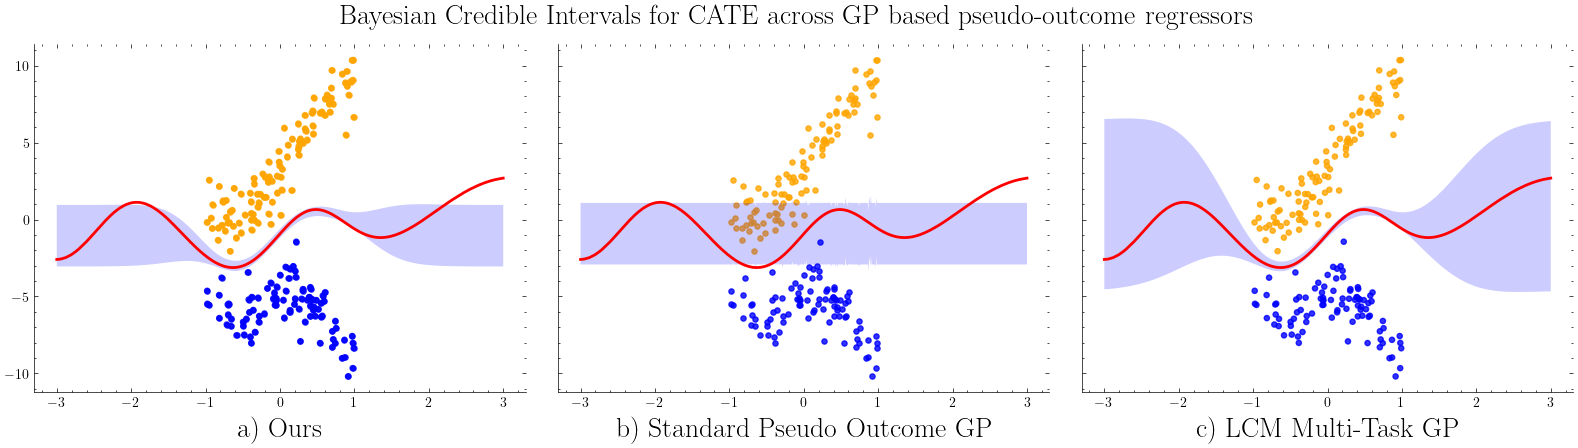

In [27]:
fig

In [28]:
handles, labels = axs[0].get_legend_handles_labels()
labels[3],labels[1] = labels[1],labels[3]
handles[1],handles[3] = handles[3],handles[1]
# legend1 = axs[0].legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
# reverse the order
legend2 =axs[0].legend(handles, labels,ncols=2,loc="upper left")
# axs[0].legend()

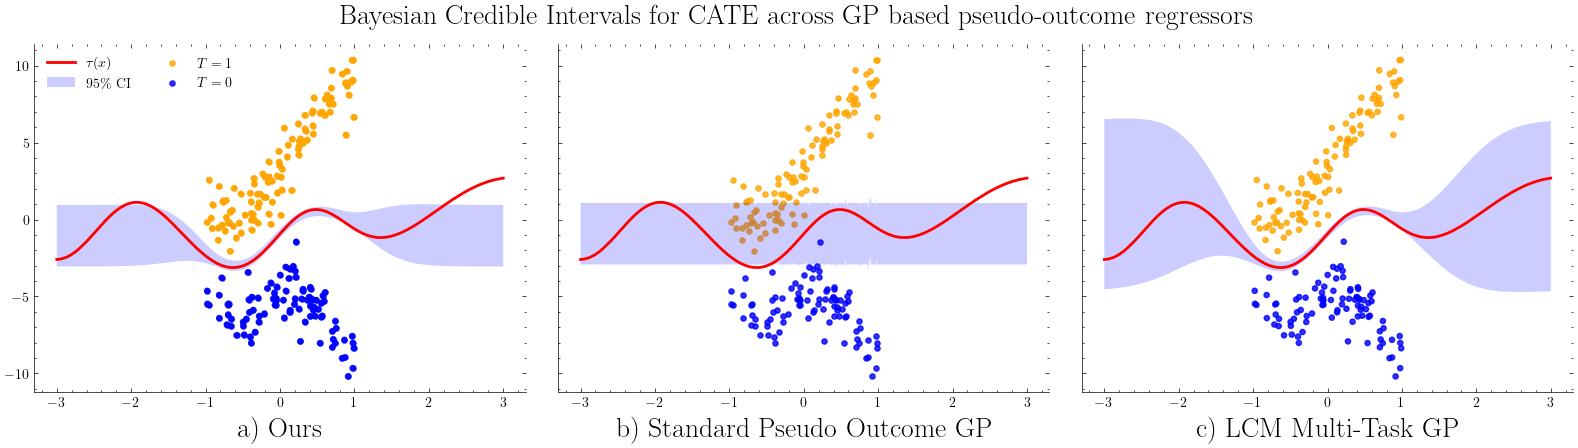

In [29]:
fig